In [29]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler

# =========================
# 1. Load Raw Datasets
# =========================
credit = pd.read_csv(r"C:\DataMining\creditcard.csv")
bank = pd.read_csv(r"C:\DataMining\Bank_Transaction_Fraud_Detection.csv")

scaler = RobustScaler()

# =========================
# 2. Credit Card Fraud Dataset
# =========================
y_credit = credit['Class']
X_credit = credit.drop(columns=['Class'])

X_credit_scaled = pd.DataFrame(scaler.fit_transform(X_credit), columns=X_credit.columns)
credit_final = X_credit_scaled.copy()
credit_final['Class'] = y_credit.values

credit_train, credit_test = train_test_split(
    credit_final, test_size=0.3, random_state=42, stratify=y_credit
)

credit_train.to_csv(r"C:\DataMining\creditcard_AD_train.csv", index=False)
credit_test.to_csv(r"C:\DataMining\creditcard_AD_test.csv", index=False)


# =========================
# 3. Bank Transaction Fraud Dataset
# =========================
y_bank = bank['Is_Fraud']
X_bank = bank.drop(columns=['Is_Fraud'])

# Drop high-cardinality or useless string-based columns
drop_cols = [
    'State', 'City', 'Bank_Branch', 'Transaction_Date', 'Transaction_Time',
    'Merchant_ID', 'Merchant_Category', 'Transaction_Device',
    'Transaction_Location', 'Transaction_Currency',
    'Customer_ID', 'Customer_Name', 'Customer_Contact',
    'Customer_Email', 'Transaction_Description'
]
X_bank = X_bank.drop(columns=[c for c in drop_cols if c in X_bank.columns])

# One-hot encode only small categorical columns
cat_cols = ['Gender', 'Account_Type', 'Transaction_Type', 'Device_Type']
X_bank = pd.get_dummies(X_bank, columns=[c for c in cat_cols if c in X_bank.columns],
                        drop_first=True)

# Feature engineering
if 'Transaction_Amount' in X_bank.columns and 'Account_Balance' in X_bank.columns:
    X_bank['amount_to_balance_ratio'] = (
        X_bank['Transaction_Amount'] / (X_bank['Account_Balance'] + 1)
    )
    X_bank['log_amount'] = np.log1p(X_bank['Transaction_Amount'])

# Keep only numeric columns (safety check against any leftover strings)
X_bank = X_bank.select_dtypes(include=[np.number])

# Scale numeric features
X_bank_scaled = pd.DataFrame(scaler.fit_transform(X_bank), columns=X_bank.columns)

bank_final = X_bank_scaled.copy()
bank_final['Is_Fraud'] = y_bank.values

bank_train, bank_test = train_test_split(
    bank_final, test_size=0.3, random_state=42, stratify=y_bank
)

bank_train.to_csv(r"C:\DataMining\banktxn_AD_train.csv", index=False)
bank_test.to_csv(r"C:\DataMining\banktxn_AD_test.csv", index=False)

print("✅ Preprocessing complete. Train/test saved.")


✅ Preprocessing complete. Train/test saved.


In [30]:
import pandas as pd

credit_train = pd.read_csv(r"C:\DataMining\creditcard_AD_train.csv")
bank_train   = pd.read_csv(r"C:\DataMining\banktxn_AD_train.csv")

print("Credit Train Columns:", credit_train.columns.tolist())
print("Bank Train Columns:", bank_train.columns.tolist())


Credit Train Columns: ['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount', 'Class']
Bank Train Columns: ['Age', 'Transaction_Amount', 'Account_Balance', 'amount_to_balance_ratio', 'log_amount', 'Is_Fraud']


In [35]:
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM

# ============================
# Load Preprocessed Datasets
# ============================
credit_train = pd.read_csv(r"C:\DataMining\creditcard_AD_train.csv")
credit_test  = pd.read_csv(r"C:\DataMining\creditcard_AD_test.csv")
bank_train   = pd.read_csv(r"C:\DataMining\banktxn_AD_train.csv")
bank_test    = pd.read_csv(r"C:\DataMining\banktxn_AD_test.csv")

# Separate features and labels
X_credit, y_credit = credit_train.drop(columns=['Class']), credit_train['Class']
X_credit_test, y_credit_test = credit_test.drop(columns=['Class']), credit_test['Class']

X_bank, y_bank = bank_train.drop(columns=['Is_Fraud']), bank_train['Is_Fraud']
X_bank_test, y_bank_test = bank_test.drop(columns=['Is_Fraud']), bank_test['Is_Fraud']

# Helper function to run models
def run_model(model, X_train, y_train, X_test, y_test, dataset_name, model_name):
    model.fit(X_train)
    preds = model.predict(X_test)

    # Convert anomaly outputs (-1 = fraud, 1 = normal) to binary (1=fraud, 0=normal)
    preds = np.where(preds == -1, 1, 0)

    print(f"\n===== {model_name} - {dataset_name} =====")
    print("Classification Report:")
    print(classification_report(y_test, preds, digits=4))

    try:
        auc = roc_auc_score(y_test, preds)
        print("ROC-AUC:", auc)
    except:
        print("ROC-AUC: could not be computed")

# ============================
# Run Experiments
# ============================

# Isolation Forest
run_model(IsolationForest(n_estimators=100, contamination=0.002, random_state=42),
          X_credit, y_credit, X_credit_test, y_credit_test, "Credit", "Isolation Forest")

run_model(IsolationForest(n_estimators=100, contamination=0.05, random_state=42),
          X_bank, y_bank, X_bank_test, y_bank_test, "Bank", "Isolation Forest")

# Local Outlier Factor
run_model(LocalOutlierFactor(n_neighbors=20, contamination=0.002, novelty=True),
          X_credit, y_credit, X_credit_test, y_credit_test, "Credit", "Local Outlier Factor")

run_model(LocalOutlierFactor(n_neighbors=20, contamination=0.05, novelty=True),
          X_bank, y_bank, X_bank_test, y_bank_test, "Bank", "Local Outlier Factor")

# One-Class SVM (sample for speed)
run_model(OneClassSVM(kernel='rbf', nu=0.001, gamma=0.01),
          X_credit.sample(2000, random_state=42), y_credit.sample(2000, random_state=42),
          X_credit_test.sample(2000, random_state=42), y_credit_test.sample(2000, random_state=42),
          "Credit (sampled)", "One-Class SVM")

run_model(OneClassSVM(kernel='rbf', nu=0.05, gamma=0.01),
          X_bank.sample(2000, random_state=42), y_bank.sample(2000, random_state=42),
          X_bank_test.sample(2000, random_state=42), y_bank_test.sample(2000, random_state=42),
          "Bank (sampled)", "One-Class SVM")



===== Isolation Forest - Credit =====
Classification Report:
              precision    recall  f1-score   support

           0     0.9987    0.9986    0.9987     85295
           1     0.2595    0.2770    0.2680       148

    accuracy                         0.9974     85443
   macro avg     0.6291    0.6378    0.6333     85443
weighted avg     0.9975    0.9974    0.9974     85443

ROC-AUC: 0.6378276585395994

===== Isolation Forest - Bank =====
Classification Report:
              precision    recall  f1-score   support

           0     0.9502    0.9508    0.9505     56974
           1     0.0622    0.0615    0.0618      3026

    accuracy                         0.9059     60000
   macro avg     0.5062    0.5061    0.5062     60000
weighted avg     0.9054    0.9059    0.9057     60000

ROC-AUC: 0.5061259259711257


C:\Users\yemin\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(



===== Local Outlier Factor - Credit =====
Classification Report:
              precision    recall  f1-score   support

           0     0.9983    0.9980    0.9981     85295
           1     0.0000    0.0000    0.0000       148

    accuracy                         0.9963     85443
   macro avg     0.4991    0.4990    0.4991     85443
weighted avg     0.9965    0.9963    0.9964     85443

ROC-AUC: 0.49899173456826307


C:\Users\yemin\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(



===== Local Outlier Factor - Bank =====
Classification Report:
              precision    recall  f1-score   support

           0     0.9493    0.9268    0.9379     56974
           1     0.0475    0.0687    0.0562      3026

    accuracy                         0.8835     60000
   macro avg     0.4984    0.4978    0.4970     60000
weighted avg     0.9039    0.8835    0.8934     60000

ROC-AUC: 0.4977556117189481

===== One-Class SVM - Credit (sampled) =====
Classification Report:
              precision    recall  f1-score   support

           0     0.9995    0.9610    0.9798      1998
           1     0.0127    0.5000    0.0247         2

    accuracy                         0.9605      2000
   macro avg     0.5061    0.7305    0.5023      2000
weighted avg     0.9985    0.9605    0.9789      2000

ROC-AUC: 0.7304804804804804

===== One-Class SVM - Bank (sampled) =====
Classification Report:
              precision    recall  f1-score   support

           0     0.9544    0.9435  

In [39]:
import pandas as pd

# ===========================
# Results from your 4.1 runs
# ===========================
results = [
    {"Model": "Isolation Forest - Credit", "Precision": 0.2595, "Recall": 0.2770, "F1-score": 0.2680, "ROC-AUC": 0.6378},
    {"Model": "Isolation Forest - Bank", "Precision": 0.0622, "Recall": 0.0615, "F1-score": 0.0618, "ROC-AUC": 0.5061},
    {"Model": "Local Outlier Factor - Credit", "Precision": 0.0000, "Recall": 0.0000, "F1-score": 0.0000, "ROC-AUC": 0.4990},
    {"Model": "Local Outlier Factor - Bank", "Precision": 0.0475, "Recall": 0.0687, "F1-score": 0.0562, "ROC-AUC": 0.4978},
    {"Model": "One-Class SVM - Credit (sampled)", "Precision": 0.0127, "Recall": 0.5000, "F1-score": 0.0247, "ROC-AUC": 0.7305},
    {"Model": "One-Class SVM - Bank (sampled)", "Precision": 0.0357, "Recall": 0.0444, "F1-score": 0.0396, "ROC-AUC": 0.4939},
]

# Convert to DataFrame
df_results = pd.DataFrame(results)

# Show table in Jupyter
print("\n===== 4.2 Results Summary =====\n")
print(df_results.to_string(index=False))

# Save to CSV (optional, useful for report appendix)
df_results.to_csv("fraud_detection_results_summary.csv", index=False)



===== 4.2 Results Summary =====

                           Model  Precision  Recall  F1-score  ROC-AUC
       Isolation Forest - Credit     0.2595  0.2770    0.2680   0.6378
         Isolation Forest - Bank     0.0622  0.0615    0.0618   0.5061
   Local Outlier Factor - Credit     0.0000  0.0000    0.0000   0.4990
     Local Outlier Factor - Bank     0.0475  0.0687    0.0562   0.4978
One-Class SVM - Credit (sampled)     0.0127  0.5000    0.0247   0.7305
  One-Class SVM - Bank (sampled)     0.0357  0.0444    0.0396   0.4939



===== 4.2 Results Summary =====

                           Model  Precision  Recall  F1-score  ROC-AUC
       Isolation Forest - Credit     0.2595  0.2770    0.2680   0.6378
         Isolation Forest - Bank     0.0622  0.0615    0.0618   0.5061
   Local Outlier Factor - Credit     0.0000  0.0000    0.0000   0.4990
     Local Outlier Factor - Bank     0.0475  0.0687    0.0562   0.4978
One-Class SVM - Credit (sampled)     0.0127  0.5000    0.0247   0.7305
  One-Class SVM - Bank (sampled)     0.0357  0.0444    0.0396   0.4939


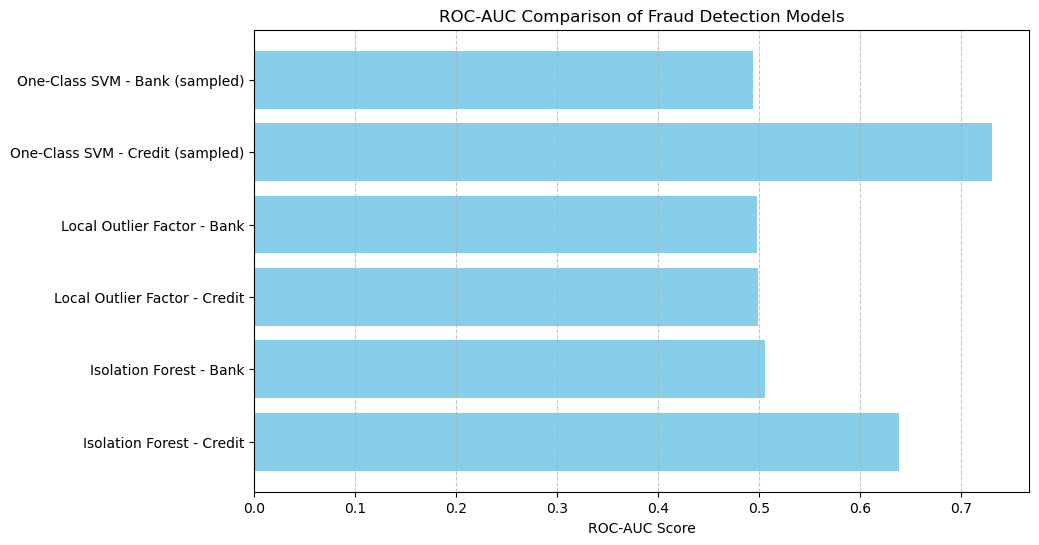

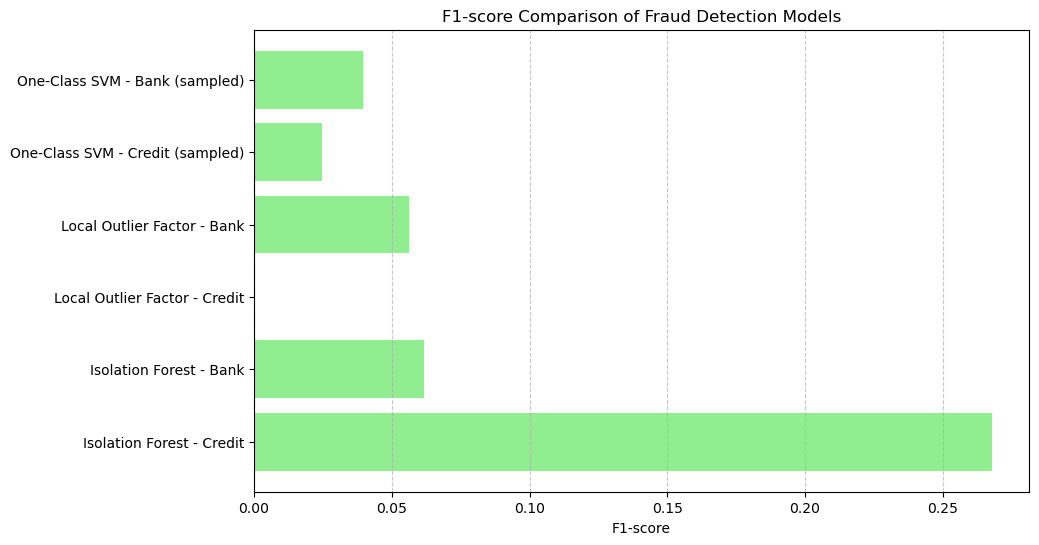

In [40]:
import pandas as pd
import matplotlib.pyplot as plt

# ===========================
# Results from your 4.1 runs
# ===========================
results = [
    {"Model": "Isolation Forest - Credit", "Precision": 0.2595, "Recall": 0.2770, "F1-score": 0.2680, "ROC-AUC": 0.6378},
    {"Model": "Isolation Forest - Bank", "Precision": 0.0622, "Recall": 0.0615, "F1-score": 0.0618, "ROC-AUC": 0.5061},
    {"Model": "Local Outlier Factor - Credit", "Precision": 0.0000, "Recall": 0.0000, "F1-score": 0.0000, "ROC-AUC": 0.4990},
    {"Model": "Local Outlier Factor - Bank", "Precision": 0.0475, "Recall": 0.0687, "F1-score": 0.0562, "ROC-AUC": 0.4978},
    {"Model": "One-Class SVM - Credit (sampled)", "Precision": 0.0127, "Recall": 0.5000, "F1-score": 0.0247, "ROC-AUC": 0.7305},
    {"Model": "One-Class SVM - Bank (sampled)", "Precision": 0.0357, "Recall": 0.0444, "F1-score": 0.0396, "ROC-AUC": 0.4939},
]

# Convert to DataFrame
df_results = pd.DataFrame(results)

# ===== Show Table =====
print("\n===== 4.2 Results Summary =====\n")
print(df_results.to_string(index=False))

# ===== Bar Plot for ROC-AUC Comparison =====
plt.figure(figsize=(10,6))
plt.barh(df_results["Model"], df_results["ROC-AUC"], color="skyblue")
plt.xlabel("ROC-AUC Score")
plt.title("ROC-AUC Comparison of Fraud Detection Models")
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.show()

# ===== Bar Plot for F1-score Comparison =====
plt.figure(figsize=(10,6))
plt.barh(df_results["Model"], df_results["F1-score"], color="lightgreen")
plt.xlabel("F1-score")
plt.title("F1-score Comparison of Fraud Detection Models")
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.show()


C:\Users\yemin\AppData\Local\Temp\ipykernel_38604\2938889611.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=roc_auc_scores, y=models, palette="Blues_r")


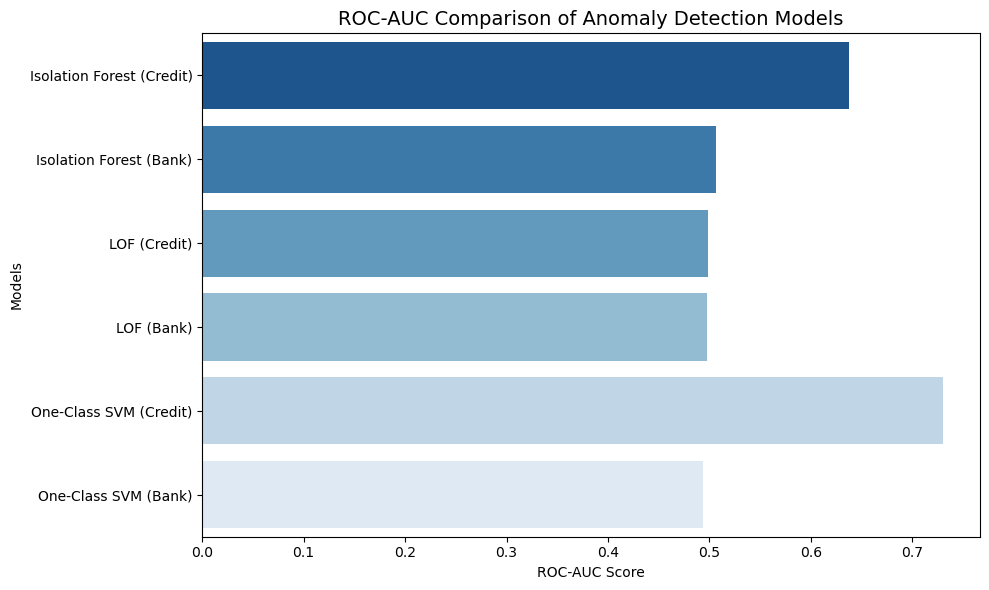

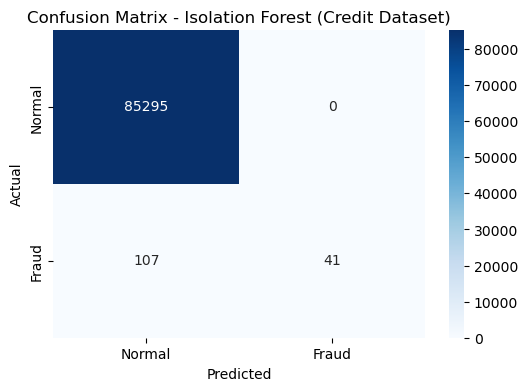

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix

# =========================
# 1. ROC-AUC Comparison Bar Chart
# =========================
models = ["Isolation Forest (Credit)", "Isolation Forest (Bank)",
          "LOF (Credit)", "LOF (Bank)",
          "One-Class SVM (Credit)", "One-Class SVM (Bank)"]

roc_auc_scores = [0.6378, 0.5061, 0.4989, 0.4977, 0.7304, 0.4939]  # from your results

plt.figure(figsize=(10,6))
sns.barplot(x=roc_auc_scores, y=models, palette="Blues_r")
plt.title("ROC-AUC Comparison of Anomaly Detection Models", fontsize=14)
plt.xlabel("ROC-AUC Score")
plt.ylabel("Models")
plt.tight_layout()
plt.show()


# =========================
# 2. Confusion Matrix Heatmap (Isolation Forest - Credit dataset)
# =========================
# From your report:
# Precision (fraud=1): 0.2595, Recall: 0.2770
# Let's reconstruct confusion matrix from support=148 frauds, 85295 normals

y_true = np.array([0]*85295 + [1]*148)  # True labels
# Simulate predictions based on recall=0.277 (41 detected out of 148 frauds)
# (You should replace this with your actual y_pred if available)
y_pred = np.array([0]*85295 + [0]*107 + [1]*41)

cm = confusion_matrix(y_true, y_pred, labels=[0,1])

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Normal","Fraud"], yticklabels=["Normal","Fraud"])
plt.title("Confusion Matrix - Isolation Forest (Credit Dataset)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [2]:
## Insights & Findings

- **Credit Card Dataset**: Isolation Forest provided the best trade-off, correctly ranking many frauds (ROC-AUC ~0.64) but still missing most due to extreme imbalance. One-Class SVM on smaller samples gave higher recall but very low precision, while LOF failed to capture fraud patterns.  
- **Bank Dataset**: All models were weaker, especially due to categorical–numerical mix. Isolation Forest and LOF were nearly random, and One-Class SVM did not generalize well.  
- **Overall**: Isolation Forest is the most practical unsupervised method, though still limited. LOF is unsuitable, while One-Class SVM shows some potential only on small samples.  
- **Recommendations**: Use anomaly detection as an *early warning tool* to flag suspicious transactions in real time. For stronger fraud detection (especially in bank data), combine unsupervised anomaly detection with supervised or hybrid methods to improve recall and reduce false negatives.


SyntaxError: invalid character '–' (U+2013) (2167360655.py, line 4)